In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#!pip install skl2onnx

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df=pd.read_excel('/content/drive/MyDrive/AI4LS_Data/LUCAS-SOIL-2018.xls')
target = 'LC1_Desc'

In [7]:
#First filter the points only for Sweden
#df = df[df['NUTS_0']=='SE']
df.shape

(18984, 27)

In [8]:
for col in ['P', 'N', 'K']:
    df.loc[df[col]=='< LOD', col] = np.nan
    df.loc[df[col]=='<0.0', col] = np.nan
    df[col]=df[col].astype(float)
for col in ['OC','CaCO3','OC (20-30 cm)','CaCO3 (20-30 cm)']:
    df.loc[df[col]=='< LOD', col] = np.nan
    df.loc[df[col]=='<  LOD', col] = np.nan
    df.loc[df[col]=='<0.0', col] = np.nan
    df[col]=df[col].astype(float)

for col in ['NUTS_0','NUTS_1','NUTS_2','NUTS_3','LC','LU','LC0_Desc','LC1_Desc','LU1_Desc']:
    df[col]=df[col].astype('category')
cols = df.columns
for c in cols:
    if df[c].dtype == 'object':
        df[c] = df[c].str.strip()

In [9]:
df['SURVEY_DATE']=pd.to_datetime(df['SURVEY_DATE'], format='%d/%m/%y')

In [10]:
cols = df.columns.tolist()
for index, c in enumerate(cols):
    cols[index] = c.replace(' ', '_')
df.columns = cols

In [11]:
from sklearn.preprocessing import LabelEncoder

# Assuming your DataFrame is named df
df_encoded = df.copy()  # Create a copy to avoid modifying the original DataFrame

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Iterate through columns and apply label encoding
for column in df_encoded.columns:
    if df_encoded[column].dtype.name == 'category':
        df_encoded[column] = label_encoder.fit_transform(df_encoded[column])

In [12]:
label_encoder.fit(df[target])
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(le_name_mapping)

{'Apple fruit': 0, 'Arable land (only PI)': 1, 'Barley': 2, 'Broadleaved woodland': 3, 'Cherry fruit': 4, 'Clovers': 5, 'Common wheat': 6, 'Cotton': 7, 'Dry pulses': 8, 'Durum wheat': 9, 'Floriculture and ornamental plants': 10, 'Grassland with sparse tree/shrub cover': 11, 'Grassland without tree/shrub cover': 12, 'Inland fresh running water': 13, 'Inland marshes': 14, 'Inland salty water bodies': 15, 'Lichens and Moss': 16, 'Lucerne': 17, 'Maize': 18, 'Mix of cereals': 19, 'Non built-up area features': 20, 'Non built-up linear features': 21, 'Nurseries': 22, 'Nuts trees': 23, 'Oats': 24, 'Olive groves': 25, 'Oranges': 26, 'Other Leguminous  and mixtures for fodder': 27, 'Other artificial areas': 28, 'Other bare soil': 29, 'Other cereals': 30, 'Other citrus fruit': 31, 'Other coniferous woodland': 32, 'Other fibre and oleaginous crops': 33, 'Other fresh vegetables': 34, 'Other fruit trees and berries': 35, 'Other mixed woodland': 36, 'Other non-permanent industrial crops': 37, 'Other 

In [13]:
# List of columns to drop
columns_to_drop = ['OC_(20-30_cm)', 'CaCO3_(20-30_cm)', 'Ox_Al', 'Ox_Fe']

# Dropping the specified columns
df_encoded = df_encoded.drop(columns=columns_to_drop)

In [14]:
import numpy as np

# Assuming df_encoded is your DataFrame
# Replace NaN values with 0 in the 'P' column
df_encoded['P'] = df_encoded['P'].replace(np.nan, 0).astype(float)

In [15]:
df_encoded['CaCO3'] = df_encoded['CaCO3'].replace(np.nan, 0).astype(float)

In [16]:
print(df_encoded.shape)
df_encoded=df_encoded.dropna()
print(df_encoded.shape)

(18984, 23)
(18900, 23)


In [17]:
df_encoded['LC0_Desc']=df_encoded['LC0_Desc'].astype(float)
print(df_encoded.dtypes)

Depth                  object
POINTID                 int64
pH_CaCl2              float64
pH_H2O                float64
EC                    float64
OC                    float64
CaCO3                 float64
P                     float64
N                     float64
K                     float64
NUTS_0                  int64
NUTS_1                  int64
NUTS_2                  int64
NUTS_3                  int64
TH_LAT                float64
TH_LONG               float64
SURVEY_DATE    datetime64[ns]
Elev                    int64
LC                      int64
LU                      int64
LC0_Desc              float64
LC1_Desc                int64
LU1_Desc                int64
dtype: object


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline

# Feature selection
features = ['pH_CaCl2', 'pH_H2O', 'EC', 'OC', 'CaCO3', 'P', 'N', 'K', 'LC0_Desc']
X = df_encoded[features]
y = df_encoded[target]

# Address class imbalance using oversampling
oversampler = RandomOverSampler()
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Initializing RandomForest classifier with manually adjusted parameters
rf_classifier = RandomForestClassifier(
    n_estimators=50,  # Adjust the number of trees
    max_depth=None,    # Adjust the maximum depth of the trees
    min_samples_split=2,  # Adjust the minimum number of samples required to split an internal node
    min_samples_leaf=1   # Adjust the minimum number of samples required to be at a leaf node
)

# Creating a pipeline with scaling and the classifier
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', rf_classifier)
])

# Fitting the model
pipe.fit(X_train, y_train)

# Making predictions on the test set
predictions = pipe.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')
print('\nClassification Report:\n', classification_report(y_test, predictions))


Accuracy: 0.9866126091807026

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       538
           1       1.00      1.00      1.00       530
           2       0.92      0.92      0.92       566
           3       0.94      0.84      0.89       573
           4       1.00      1.00      1.00       592
           5       1.00      1.00      1.00       604
           6       0.94      0.80      0.87       557
           7       1.00      1.00      1.00       569
           8       1.00      1.00      1.00       532
           9       0.99      1.00      1.00       580
          10       1.00      1.00      1.00       574
          11       0.95      1.00      0.97       553
          12       0.97      0.82      0.89       532
          13       1.00      1.00      1.00       549
          14       1.00      1.00      1.00       562
          15       1.00      1.00      1.00       573
          16       1.00    

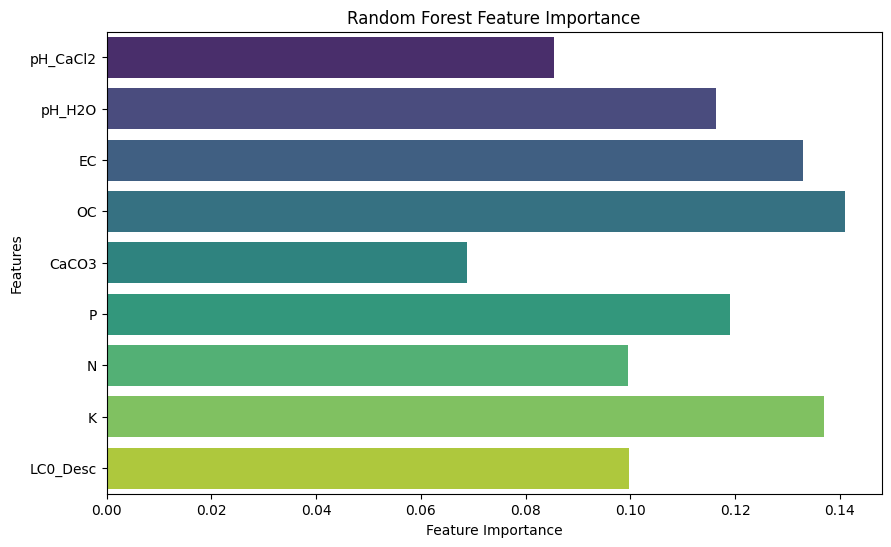

In [19]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# Access the decision tree from the RandomForestClassifier
# Note: If you used a specific index for the tree you want to visualize, provide it as tree_index parameter
decision_tree = pipe.named_steps['classifier'].estimators_[0]

# Get unique classes from your target variable
unique_classes = np.unique(y_train)

# Visualize the decision tree
#plt.figure(figsize=(20, 10))
#plot_tree(decision_tree, feature_names=features, class_names=[str(cls) for cls in unique_classes], filled=True, rounded=True)
#plt.show()

# Access feature importances from the RandomForestClassifier
feature_importances = pipe.named_steps['classifier'].feature_importances_

# Visualize feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=features, palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.show()


In [20]:
#saving the built model
#model.save_model(f'{target}.model')

# import joblib
# joblib.dump(pipe,f'{target}.joblib')


In [21]:
#!pip install skl2onnx

In [22]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType, Int64TensorType
from skl2onnx import to_onnx

# Disable zipmap as it is not supported in BigQuery ML.
options = {id(pipe): {'zipmap': False}}

initial_types = [
   ('pH_CaCl2', FloatTensorType([None, 1])),
   ('pH_H2O', FloatTensorType([None, 1])),
   ('EC', FloatTensorType([None, 1])),
   ('OC', FloatTensorType([None, 1])),
   ('CaCO3', FloatTensorType([None, 1])),
   ('P', FloatTensorType([None, 1])),
   ('N', FloatTensorType([None, 1])),
   ('K', FloatTensorType([None, 1])),
   ('LC0_Desc', FloatTensorType([None, 1]))
]

# Convert the model.
model_onnx = convert_sklearn(
   pipe, 'pipeline_rf', initial_types=initial_types, options=options
)
onnxFileName = f'{target}_ONNX.onnx'
onnxCompressedFileName = f'{target}_ONNX.zip'
with open(onnxFileName, "wb") as f:
    f.write(model_onnx.SerializeToString())

In [23]:
from zipfile import *
with open(onnxFileName, "wb") as f:
    f.write(model_onnx.SerializeToString())
ZipFile(onnxCompressedFileName, "w", ZIP_DEFLATED).write(onnxFileName)